# 📌 Fear and Greed Index 구성 요소 정리

## ✅ Fear and Greed Index란?
- CNN에서 제공하는 **시장 심리 지표**로, **0(극단적 공포) ~ 100(극단적 탐욕)** 사이의 값을 가짐.
- **7가지 핵심 지표**를 기반으로 계산되며, 시장의 위험 선호도(탐욕) 또는 위험 회피(공포)를 분석하는 데 사용됨.

---

## ✅ Fear and Greed Index 관련 데이터 (7가지 핵심 지표 중 4가지)

['market_momentum_sp500', 'market_momentum_sp125', 
                'stock_price_strength', 'stock_price_breadth', 'put_call_options', 
                'market_volatility_vix', 'market_volatility_vix_50', 'junk_bond_demand', 'safe_haven_demand']

| **지표명** | **설명** | **해석** |
|------------------------|--------------------------------------|--------------------------------|
| `market_momentum_sp500` | S&P 500 지수 | 시총 상위 500개 기업 지수 |
| `market_momentum_sp125` | S&P 500 지수의 125일 이동평균 (모멘텀) | S&P가 이동평균 위면 강한 시장, 아래면 약한 시장 |
| `put_call_options` | 옵션 시장에서 풋(하락 베팅) vs. 콜(상승 베팅) 비율 | 0.6 ~ 1.8 사이가 일반적. <수치가 낮을수록 탐욕> |
| `safe_haven_demand` | 주식 vs. 채권 선호도 비교 | 주식 선호 → 위험 감수(탐욕), 채권 선호 → 안전 선호(공포), <수치가 낮을수록 탐욕> |
----

In [1]:
import requests, json
from datetime import datetime, timedelta

import pandas as pd


# 현재 날짜
today = datetime.today()

# 3년 전 날짜 계산
three_years_ago = today.replace(year=today.year - 3)

# "YYYY-MM-DD" 형식으로 변환
formatted_date = three_years_ago.strftime("%Y-%m-%d")

# URL & header 지정
BASE_URL = "https://production.dataviz.cnn.io/index/fearandgreed/graphdata"
START_DATE = formatted_date
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36"
}

response = requests.get("{}/{}".format(BASE_URL, START_DATE), headers=headers)
data = response.json()

In [2]:
data.keys()

dict_keys(['fear_and_greed', 'fear_and_greed_historical', 'market_momentum_sp500', 'market_momentum_sp125', 'stock_price_strength', 'stock_price_breadth', 'put_call_options', 'market_volatility_vix', 'market_volatility_vix_50', 'junk_bond_demand', 'safe_haven_demand'])

In [51]:
import pandas as pd

# 데이터 컬럼 리스트
data_columns = ['fear_and_greed_historical', 'market_momentum_sp500', 'market_momentum_sp125', 
                'put_call_options', 'market_volatility_vix', 'safe_haven_demand']

# 데이터 정리
parsed_data = {
    col: {
        datetime.utcfromtimestamp(entry["x"] / 1000).strftime("%Y-%m-%d"): entry["y"]
        for entry in data[col]["data"]
    }
    for col in data_columns
}

# 날짜 리스트 추출 (모든 컬럼의 날짜를 포함)
all_dates = sorted(set(date for col in parsed_data.values() for date in col.keys()))

# 데이터프레임 생성
df = pd.DataFrame({"date": all_dates})

# 컬럼별 데이터 매핑
for col in data_columns:
    df[col] = df["date"].map(parsed_data[col])

# 날짜 정렬
df = df.sort_values(by="date")

# NaN이 있는 행(row) 전체 삭제
df_cleaned = df.dropna()

# date type
df_cleaned.loc[:, "date"] = pd.to_datetime(df_cleaned["date"])

In [62]:
df_cleaned

,date,fear_and_greed_historical,market_momentum_sp500,market_momentum_sp125,put_call_options,market_volatility_vix,safe_haven_demand
0,2022-03-21 00:00:00,40.971429,4461.18,4525.48640,0.759133,23.53,6.973117
1,2022-03-22 00:00:00,44.542857,4511.61,4526.41416,0.714828,22.94,10.214316
2,2022-03-23 00:00:00,45.200000,4456.24,4526.47224,0.683946,23.57,6.814903
3,2022-03-24 00:00:00,46.914286,4520.16,4526.98968,0.653735,21.67,6.219800
4,2022-03-25 00:00:00,49.371429,4543.06,4527.78928,0.657414,20.81,9.015823
...,...,...,...,...,...,...,...
751,2025-03-13 00:00:00,16.046825,5521.52,5900.85216,0.834487,24.66,-11.618944
752,2025-03-14 00:00:00,20.942857,5638.94,5901.19760,0.830022,21.77,-8.953780
753,2025-03-17 00:00:00,22.371429,5675.12,5901.59040,0.821321,20.51,-9.134485
754,2025-03-18 00:00:00,20.200000,5614.66,5901.44296,0.796929,21.70,-10.626729


In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# big_columns
big_columns = ['market_momentum_sp500', 'market_momentum_sp125']
medium_columns = ['put_call_options', 'market_volatility_vix']
small_columns = ['safe_haven_demand']

<Figure size 1200x600 with 0 Axes>

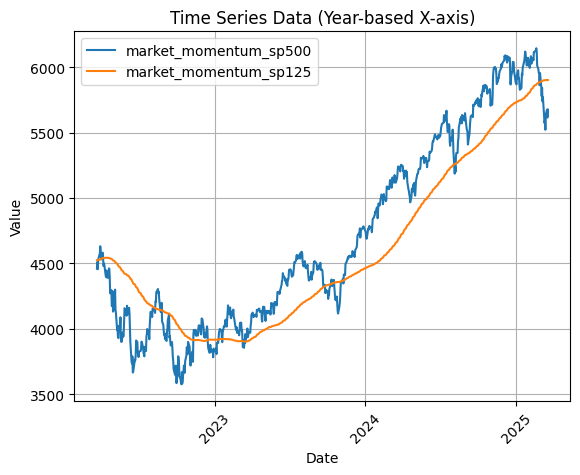

In [16]:
# x축을 날짜, y축을 각 컬럼 값으로 하는 그래프 그리기
for col in ['market_momentum_sp500', 'market_momentum_sp125']:
    plt.plot(df_cleaned["date"], df_cleaned[col], label=col)

# x축 날짜 포맷 변경 (연 단위 또는 월 단위로 축약)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # 연 단위 간격 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 연도만 표시

# 그래프 제목 및 레이블
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Time Series Data (Year-based X-axis)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# 그래프 출력
plt.show()

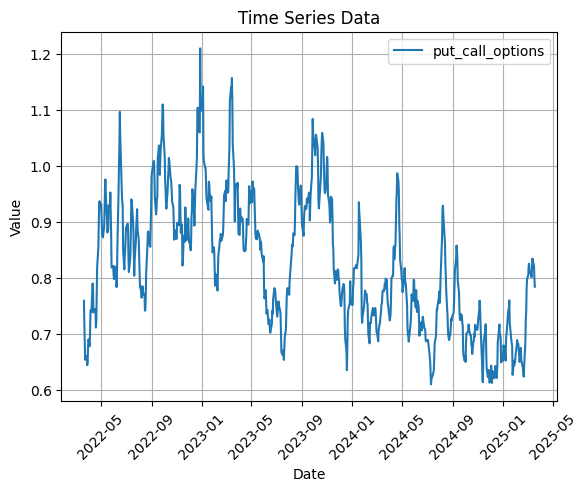

In [20]:
# x축을 날짜, y축을 각 컬럼 값으로 하는 그래프 그리기
for col in ['put_call_options']:
    plt.plot(df_cleaned["date"], df_cleaned[col], label=col)

# 그래프 제목 및 레이블
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Time Series Data")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# 그래프 출력
plt.show()

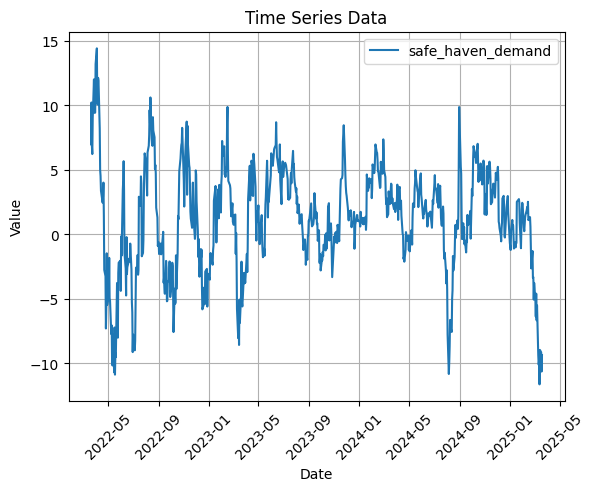

In [22]:
# x축을 날짜, y축을 각 컬럼 값으로 하는 그래프 그리기
for col in ['safe_haven_demand']:
    plt.plot(df_cleaned["date"], df_cleaned[col], label=col)

# 그래프 제목 및 레이블
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Time Series Data")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# 그래프 출력
plt.show()